In [1]:
import numpy as np
import os

np.random.seed(42) # Keep it consistent with every run

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "Classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    


In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

mnist["data"], mnist["target"]


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
print(28 * 28) # 784 attibutes because each image is 28 x 28 pixels, and the value ranges from 0 (white) to 255 (black)

784


Saving figure example_digit_plot


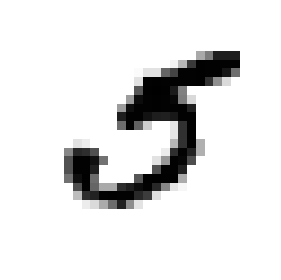

In [5]:
def plot_digit(data):
    # function for plotting quickly
    image = data.reshape(28, 28) # unflatten the vector into an array
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

example_digit = X[36000]
plot_digit(example_digit)

save_fig('example_digit_plot')
plt.show()

In [6]:
y[36000] # The above looks like a 5 and the label should be 5

5

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # Split the dataset

# Shuffle the training set to gurantee cross-val folds are similar and have all digits
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] 

## Training a Binary Classifier (One vs all)

In [8]:
y_train_5 = (y_train == 5) # boolean vector
y_test_5 = (y_test == 5)

Stochastic	Gradient	Descent classifier, good for handling large datasets as it handles instances one at a time

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42) # relies on randomness, so to keep it consistent use a random state
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([example_digit])

array([ True])

Great! The classifier thinks our example digit is a 5 (true)

## Perfomance measures

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

**Looks hella good, 95% accuracy?**

But realize that only around 10% of the data is actually 5's, so even a dumb model that predicted non-5 no matter what would still get around 90% accuracy.

Better to use a **confusion matrix**

In [12]:
# First need a set of predictions that will be compared to actual targets.
from sklearn.model_selection import cross_val_predict # Similar to cross_val_score() but insteadd returns the predictions made
# on each fold

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

y_train_pred

array([False, False, False, ..., False, False, False])

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In a confusion matrix, each row corresponds to the **actual** class, and each the column the **prediction**.

ex) The number of times a classifier predicts a 5 as a 3 can be found at the 5th row, 3rd column.

*So*, in the one above, 
 - the 53272 is the number of times non-5 was predicted non-5 (true negative)
 - 1307 is number of times non-5 precited as 5 (false positive)
 - 1077 number of times 5 predicted as non-5 (false negative)
 - 4344 number of times 5 predicted as 5 (true positive)
 
Thus if a classifier was perfect, the confusion matrix would be 0 *everywhere except the main diagonal*.

In [14]:
example_perfect_y = y_train_5
confusion_matrix(y_train_5, example_perfect_y)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Confusion matricies provide a lot of information, but let's also look at a metric that measures the accuracy of the *postiive* predictions. 

This is called the *precision* of the classifier.

**precision = TP / (TP + FP)** - ration of true positive to appears positive

where TP - true positive, FP - false positive

Precision is used alongside *recall*

**recall = TP / (TP + FN)** - ratio of true positive to actually positive

where FN - false negative

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [16]:
4344 / (4344 + 1307) # Numbers from the confusion matrix

0.7687135020350381

In [17]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [19]:
4344 / (4344 + 1077) # Again from the confusion matrix

0.801328168234643

This means that when the classifier thinks an image is a 5, it is only right ~76% of the time.
And it only manages to detect ~80% of the 5's

A useful metric is the *F1 score*, that measures a harmonic mean of precision and recall.

**F1 = 2 * (precision * recall) / (precision + recall)**

It's a harmonic mean so it gives more weight to low values, and thus to have a high F1 score, both precision and recall need to be high.

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7846820809248555

**As can be seen, F1 score favours classifiers with similar precision and recall. This is not always desireable.**

ex) i) filter child safe vids, want high precision even if safe videos get filtered out accidentally (low recall)

ii) catch shoplifters, can have low precision but want high recall (might have false alarms, but want to catch all potential thieves)


In fact increasing precision decreases recall, and vice versa. This is called the *precision/recall tradeoff*

In [21]:
y_scores = sgd_clf.decision_function([example_digit]) # Can look directly at the decision scores the classifer is assigning to 
# each instance and see what the threshold is
y_scores

array([161855.74572176])

By default the threshold is 0. (so non-5's would have a negative score). By raising this threshold, we increase precision by only selecting instances where we are very sure, but we decrease recall as more true positives become false negatives.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method="decision_function") # cross_val_predict but return descision scores instead

y_scores.shape

(60000,)

**Now we can look at the different precision/recall combos depending on our threshold**

Saving figure precision_recall_vs_threshold_plot


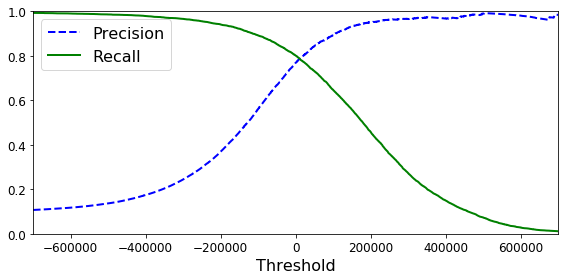

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

**Notice how recall curve is smooth but decsion curve gets bumpy**

This is because recall will always decrease as threshold increases, but sometimes precision does not increase with an increase in threshold.

ex) 5 | 5 6 5 5 5 - precision is 4/5 = 80%. Increase threshold -> 5 5 | 6 5 5 5 - precision is now 3/4 = 75%.

Whereas for recall, you will always get either a TP or a FN added to the denominator, decreasing it.

Saving figure precision_vs_recall_plot


<function matplotlib.pyplot.show(*args, **kw)>

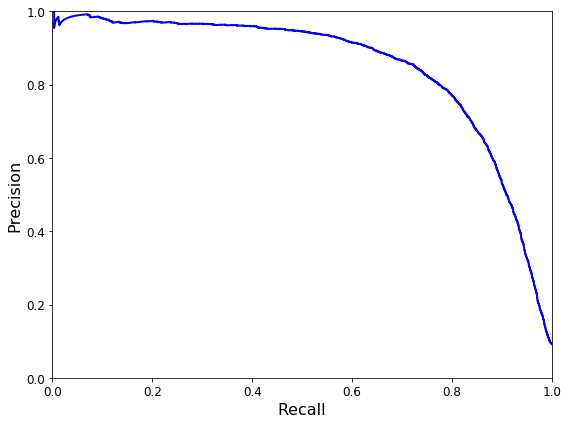

In [24]:
def plot_precision_vs_recall(precisions, recalls):
    # Directly plot precision against recall
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show

Can see that precision starts to drop off very rapidly at around 80% recall.

Suppose you wanted precision of 90%. Looking at the first graph, can see that's at around 100 000 threshold.

In [29]:
y_train_pred_90 = (y_scores > 100000)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.8935031847133758
0.646928610957388


By setting threshold to be 100 000, we now have a ~90% precise classifier. But we must consider the recall as well, a classifer with a low recall score is not very useful either.

**The ROC(reciever operating characteristic) curve is another commonly used tool.**

ROC plots the *true positive rate* (recall) against the *false positive rate*.

**FPR = FP / (FP + TN)** - ratio of false positive to actual negatives

FPR is also equal to 1 - true negative rate (TNR).

**TNR = TN / (FP + TN)** - ratio of true negative to actual negatives


Where TNR is also called *specificity* and recall is called *sensitivity*

**So the ROC plots sensitivity against 1 - specificity**

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # tpr is recall